# Cervical Cancer Analysis
## Alexander Munoz, Atousa Nourmahnad, Tina Zeina

In [39]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
# prettify graphs
def prettify_ax(ax):
    ''' make an axis pretty '''
    for spine in ax.spines.itervalues():
        spine.set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    ''' single prettified axis '''
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax

In [37]:
# read in data
data = pd.read_csv('UCI_data.csv')
print 'Shape: ', data.shape
data.head()

Shape:  (858, 36)


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


***We can see that there are missing values in the dataset, we first investigate these.***
## Missing Data

In [40]:
missings = np.zeros(data.shape[1])
for colnum in range(data.shape[1]):
    colcurr = data.iloc[:,colnum]
    try:
        missings[colnum] = sum(colcurr=='?')/len(colcurr)
    except TypeError:
        missings[colnum] = 0

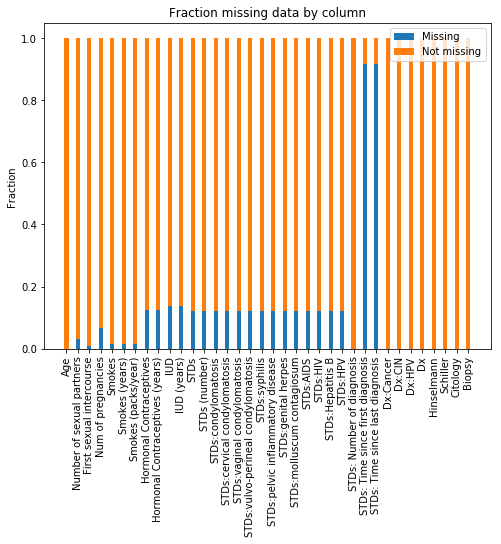

In [56]:
plt.figure(figsize=(8,6))
ind = np.arange(len(missings))
width = 0.35
p1 = plt.bar(ind, missings, width)
p2 = plt.bar(ind, 1-missings, width, bottom=missings)
plt.ylabel('Fraction')
plt.title('Fraction missing data by column')
plt.xticks(ind, data.columns.values, rotation=90)
plt.legend((p1[0], p2[0]), ('Missing', 'Not missing'))
plt.show()

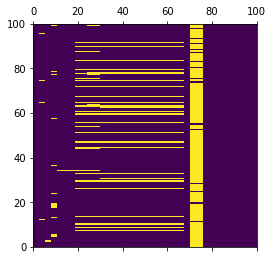

In [77]:
missings = np.zeros((data.shape[0], data.shape[1]+1))
for colnum in range(data.shape[1]):
    colcurr = data.iloc[:,colnum]
    try:
        missings[:,colnum] = (colcurr=='?').astype('int')
    except TypeError:
        missings[:,colnum] = np.zeros(data.shape[0])
plt.matshow(missings, extent=[0,100,0,100])
plt.show()

***We will first drop the two columns with many missing values. We will then investigate two methods of filling the other missing values.***

In [31]:
len(colcurr)

858